# **Assignment**

- Perform a train test split on the train.csv so you can evaluate the
models.
- Create and evaluate 3 iterations of a deep learning model to predict housing prices using the techniques to optimize the model's performance.
- Include some form of regularization with at least one model.
- Select best model!

# **Data Dictionary**

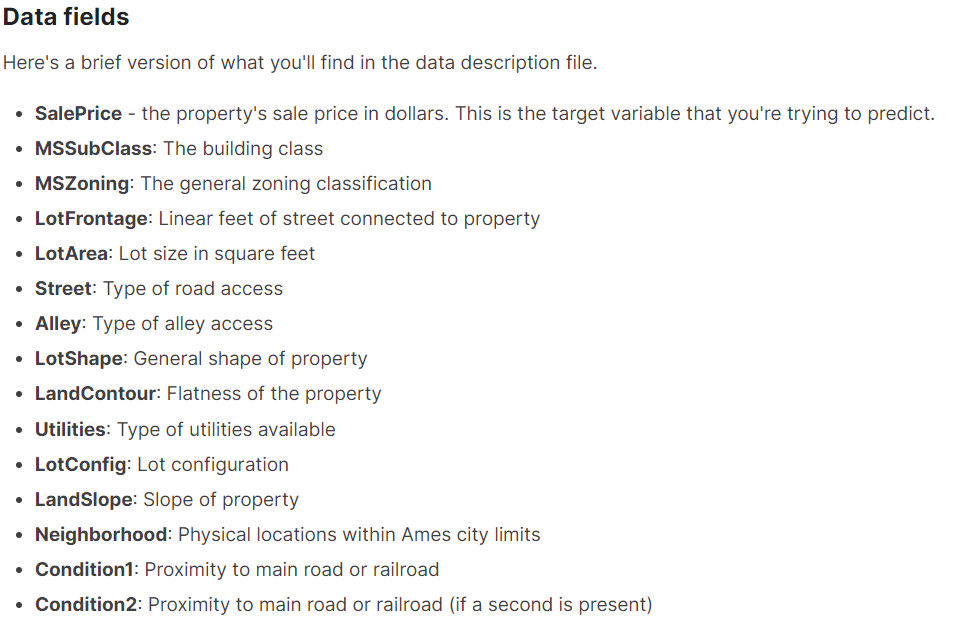

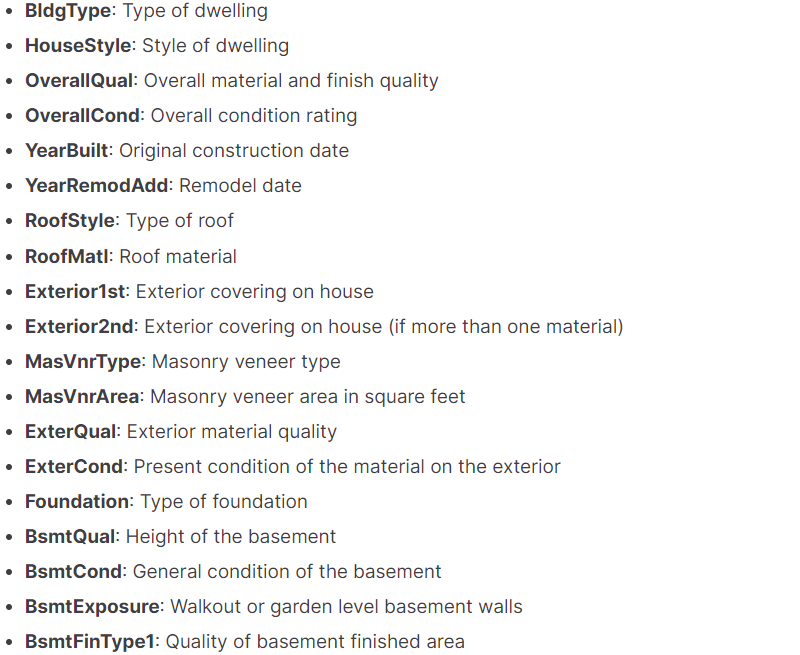

# **Imports**

In [1]:
## Pandas
import pandas as pd
## Numpy
import numpy as np
## Matplotlib
import matplotlib.pyplot as plt
## Seaborn
import seaborn as sns

## Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_absolute_error, r2_score, \
mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

# new libraries
import tensorflow as tf
import keras as keras
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import Adam
from keras import optimizers, metrics, regularizers

# This is used to overcome an issue with setting up tensorflow in M1/M1
# Suspect tensorflow-macos not very fit with GPU, use CPU only with
tf.config.set_visible_devices([], 'GPU')

# Set random seeds for consistent outcomes
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

# **Functions**

In [2]:
#Since we will be plotting histories for all of the models,
#lets create a function to do it quickly.

def plot_history(history):
  """Takes a keras model learning history and plots each metric"""

  metrics = history.history.keys()

  for metric in metrics:
      if not 'val' in metric:
        plt.plot(history.history[f'{metric}'], label=f'{metric}')
        if f'val_{metric}' in metrics:
          plt.plot(history.history[f'val_{metric}'], label=f'val_{metric}')
        plt.legend()
        plt.title(f'{metric}')
        plt.show()

def eval_regression(true, pred, name='Model'):
    """Evaluates true and predicted values from a regression model.
    Outputs a dataframe of metrics"""
    scores = pd.DataFrame()
    scores['Model Name'] = [name]
    scores['RMSE'] = [np.sqrt(mean_squared_error(true, pred))]
    scores['MAE'] = [mean_absolute_error(true, pred)]
    scores['R2'] = [r2_score(true, pred)]
    scores.set_index('Model Name', inplace=True)

    return scores

# **Load & Copy the Data**

In [3]:
#Load the Data
df = pd.read_csv('/content/train.csv')

# Copy of original data
df_backup = df.copy()

# **Explore the Data**

In [4]:
# Display the first (5) rows of the dataframe
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [6]:
# Display the number of rows and columns for the dataframe
df.shape
print(f'There are {df.shape[0]} rows, and {df.shape[1]} columns.')
print(f'The rows represent {df.shape[0]} observations, and the columns represent {df.shape[1]-1} features and 1 target variable.')

There are 1460 rows, and 81 columns.
The rows represent 1460 observations, and the columns represent 80 features and 1 target variable.


In [7]:
## Display the descriptive statistics for the numeric columns
df.describe(include="number")

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [8]:
## Display the descriptive statistics for the non-numeric columns
df.describe(exclude='number')

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,...,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,...,870,605,1311,1326,1340,3,157,49,1267,1198


In [9]:
# Display the number of duplicate rows in the dataset
print(f'There are {df.duplicated().sum()} duplicate rows.')

There are 0 duplicate rows.


In [10]:
# Display the total number of missing values
print(f'There are {df.isnull().sum().sum()} missing values.')

There are 6965 missing values.


In [11]:
# check values of categorical columns
cat_cols = list(df.select_dtypes(include = 'object'))
for col in cat_cols:
    print(col)
    print(df[col].value_counts(dropna = False))
    print()

MSZoning
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

Street
Pave    1454
Grvl       6
Name: Street, dtype: int64

Alley
NaN     1369
Grvl      50
Pave      41
Name: Alley, dtype: int64

LotShape
Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64

LandContour
Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64

Utilities
AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64

LotConfig
Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64

LandSlope
Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64

Neighborhood
NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
StoneBr     25
SWISU       25
Meado

# **Exploratory Data Analysis (EDA)**

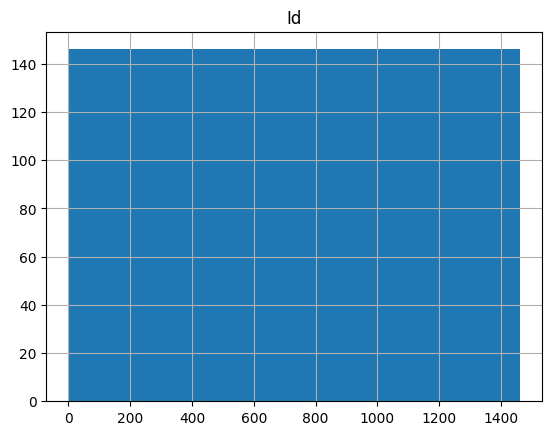

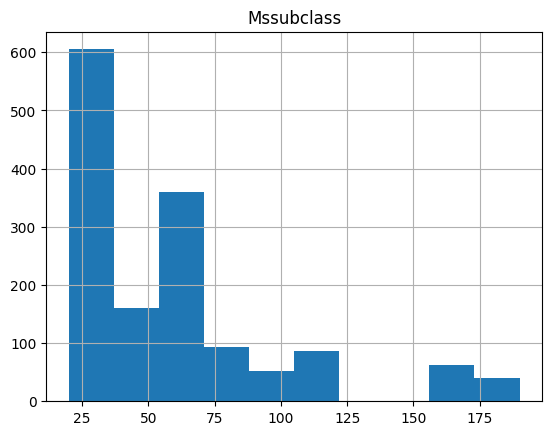

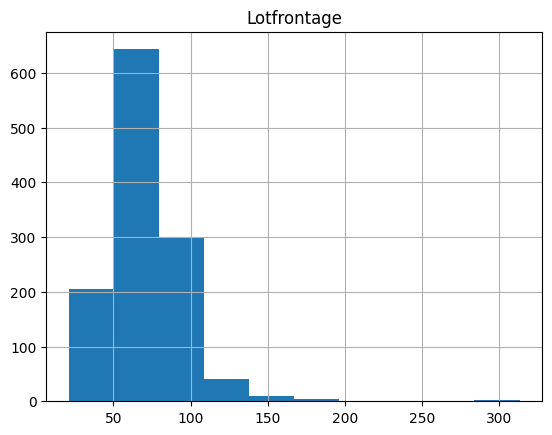

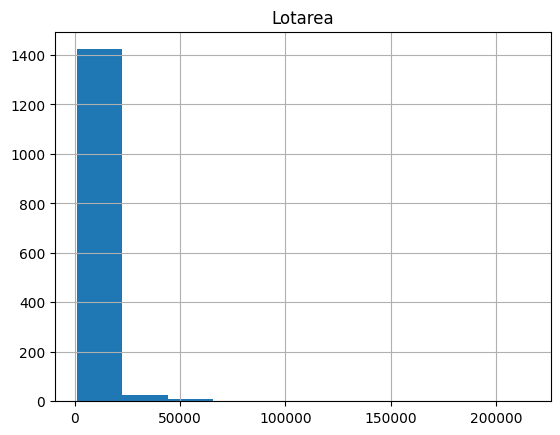

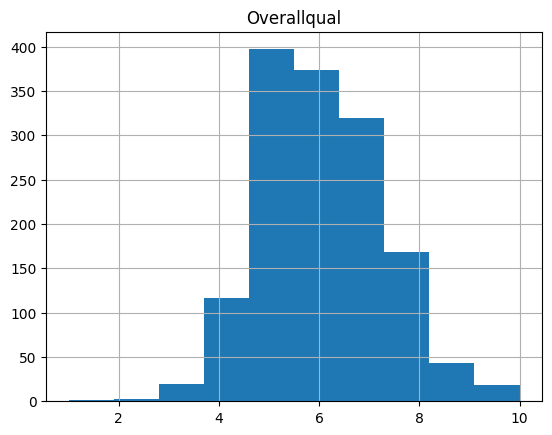

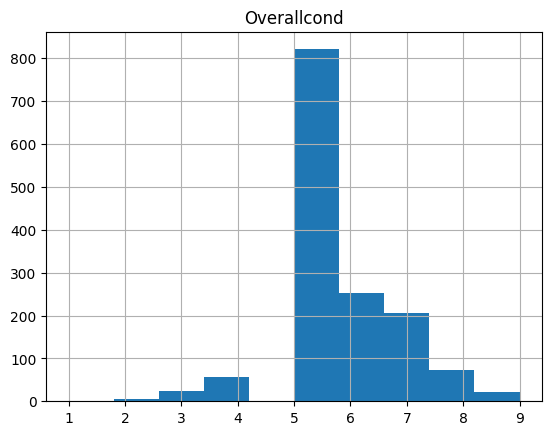

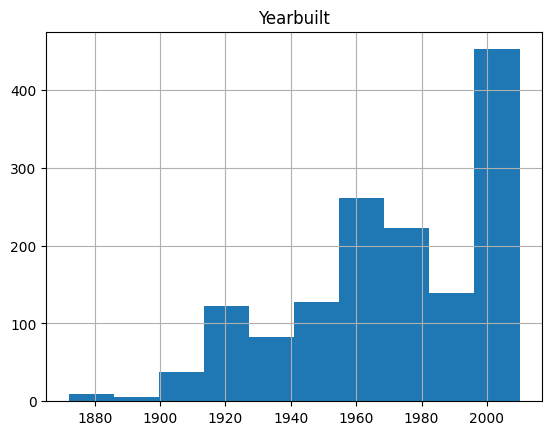

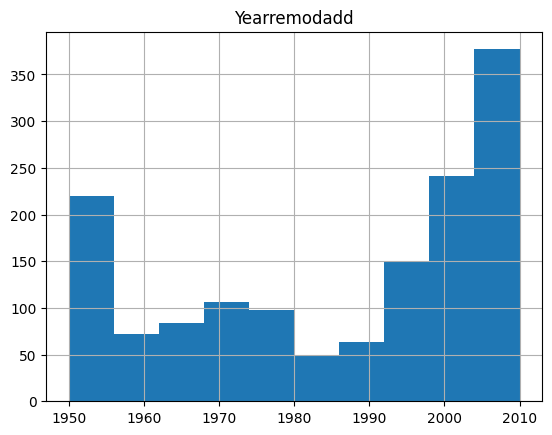

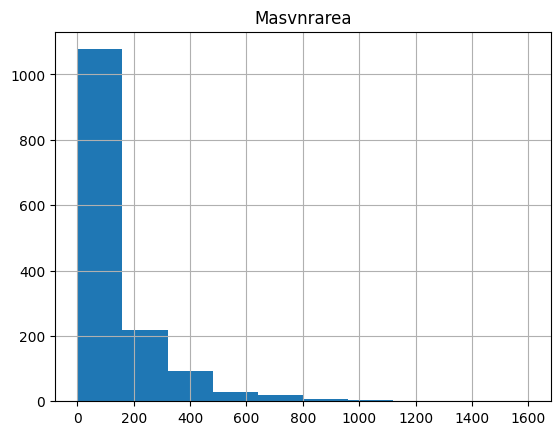

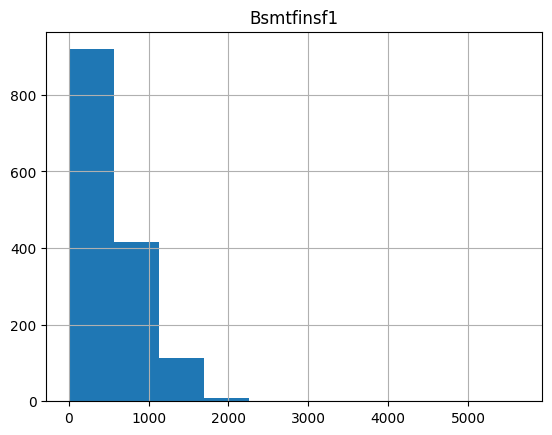

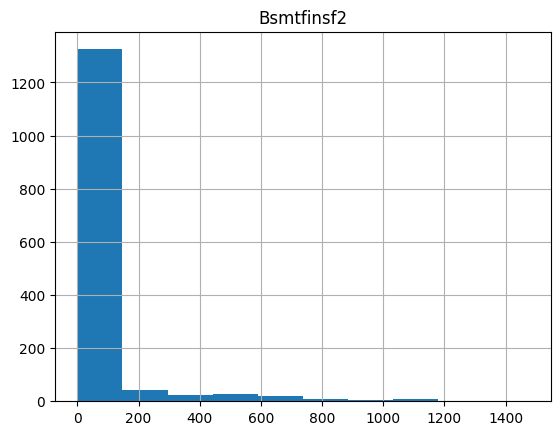

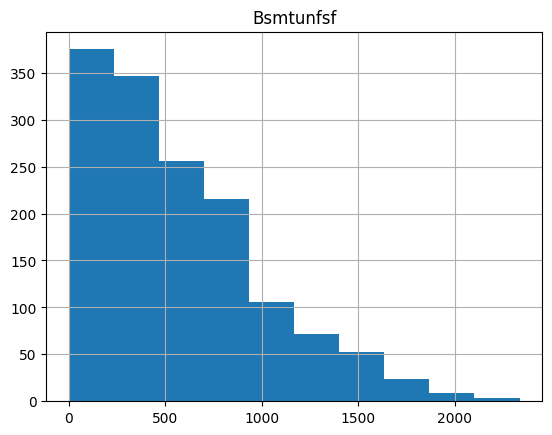

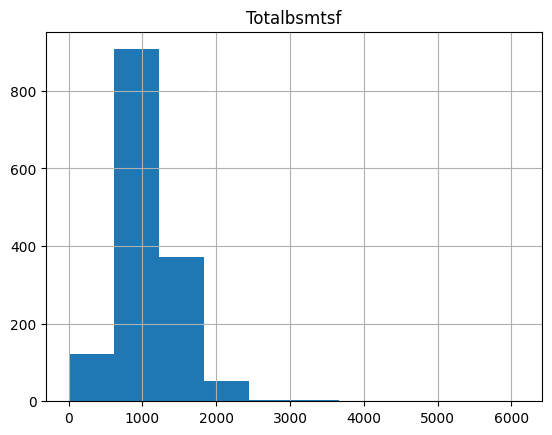

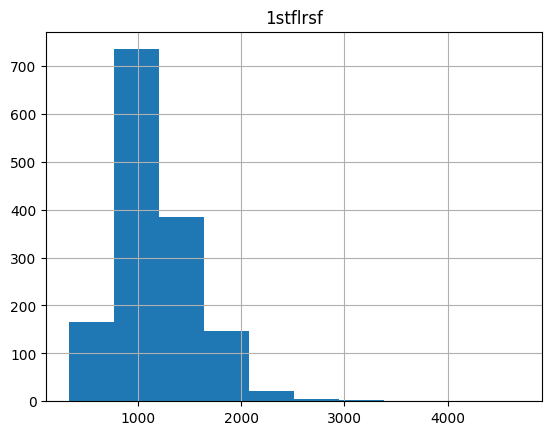

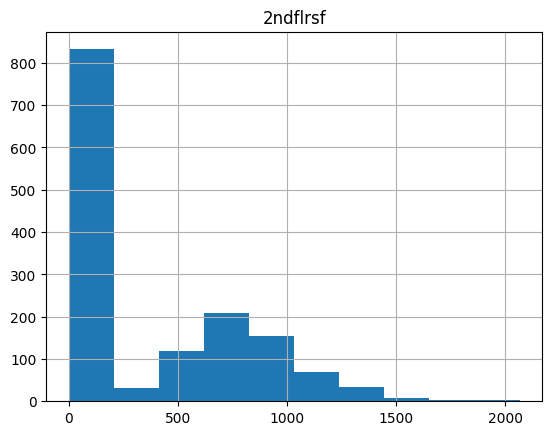

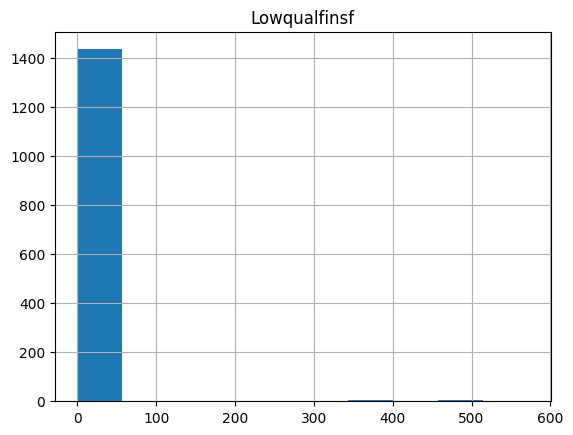

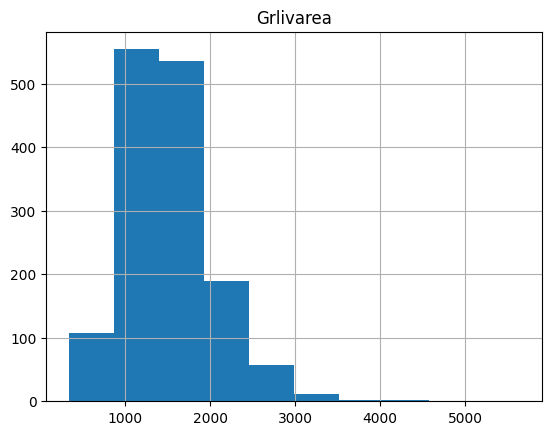

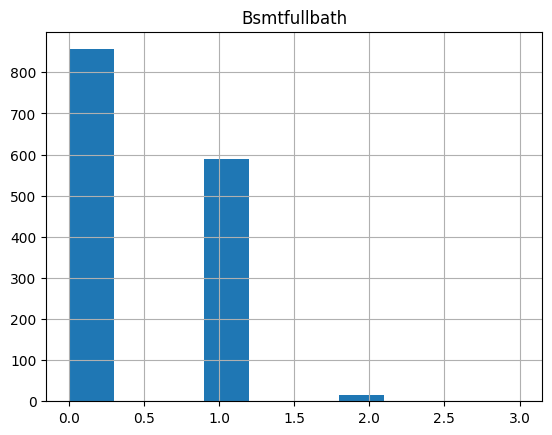

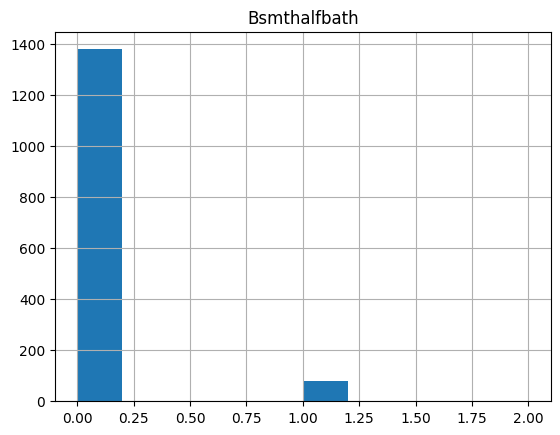

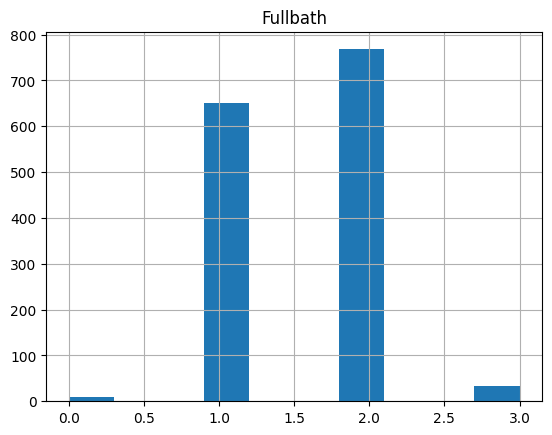

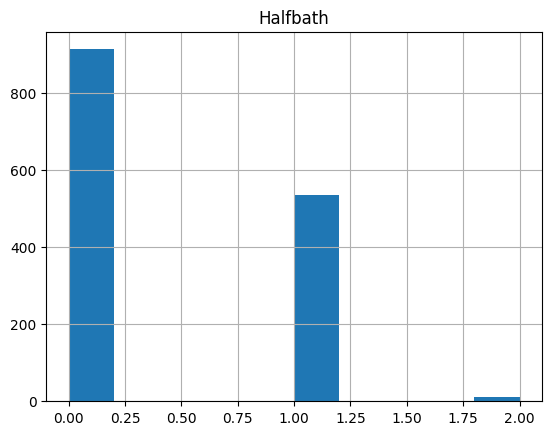

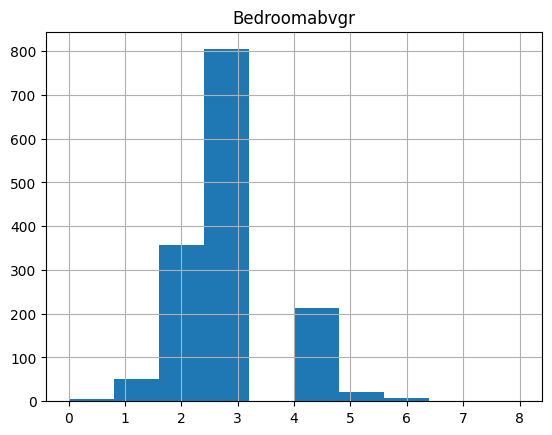

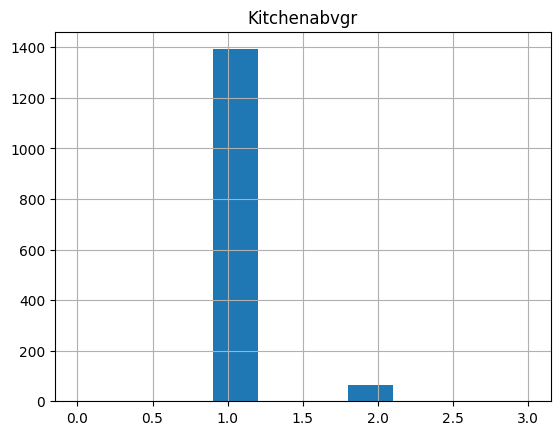

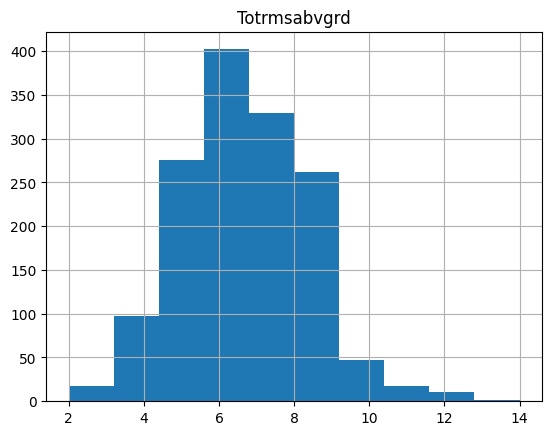

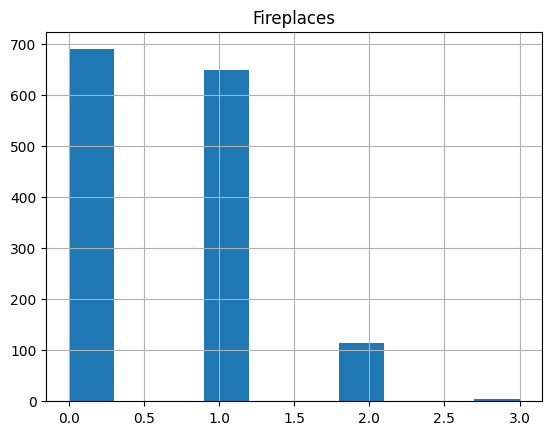

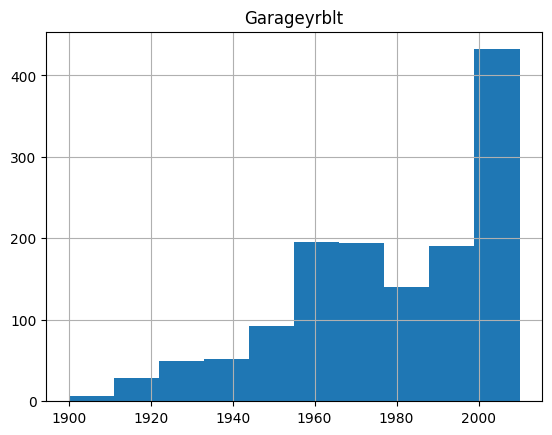

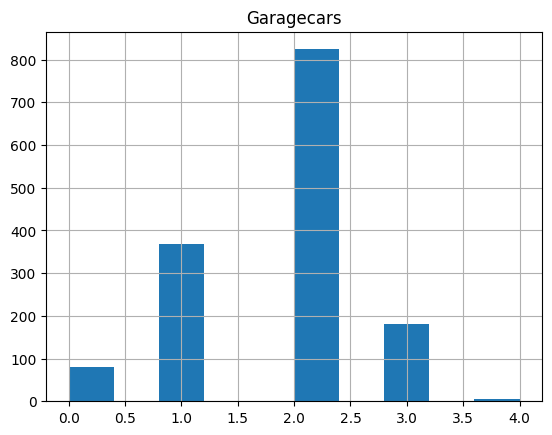

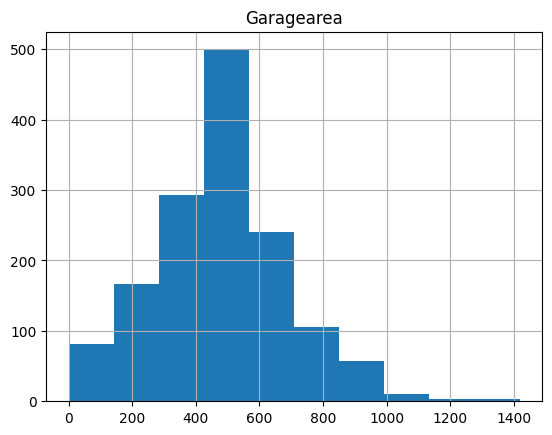

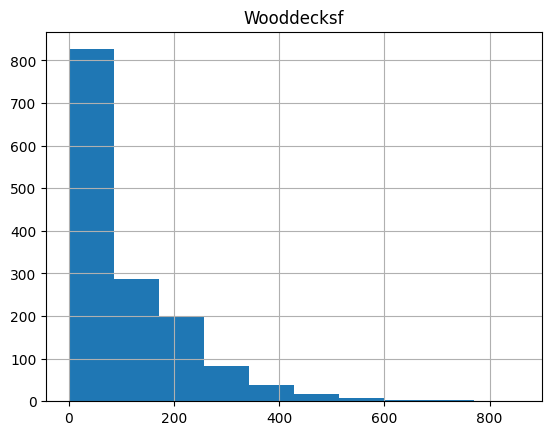

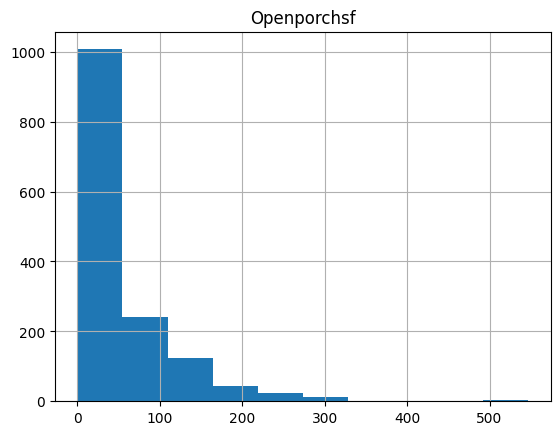

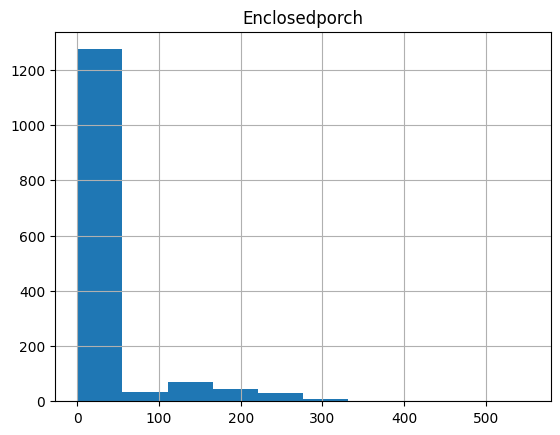

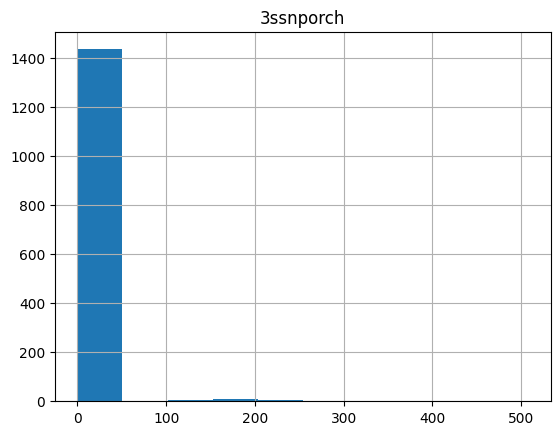

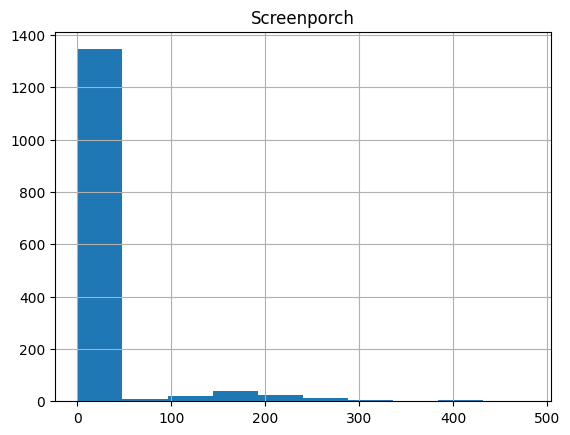

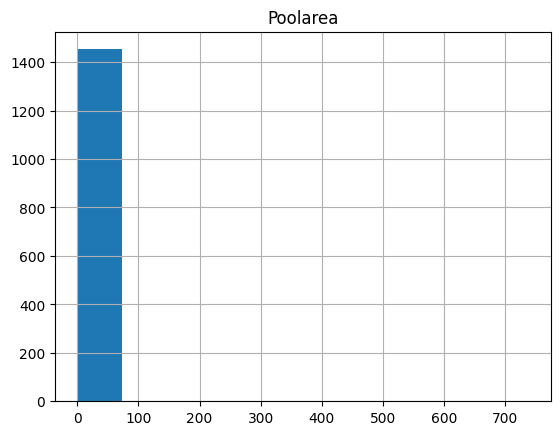

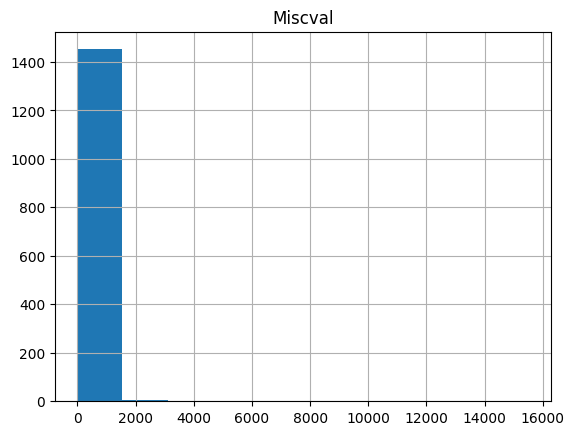

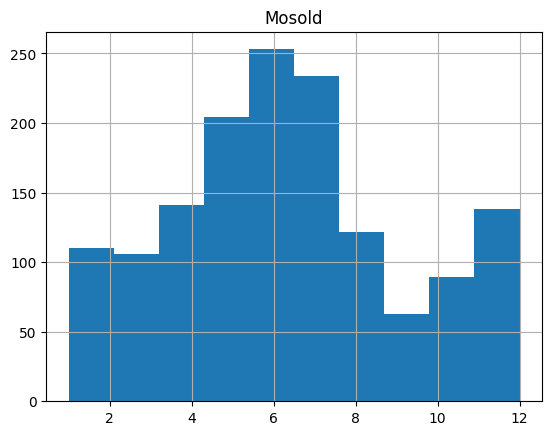

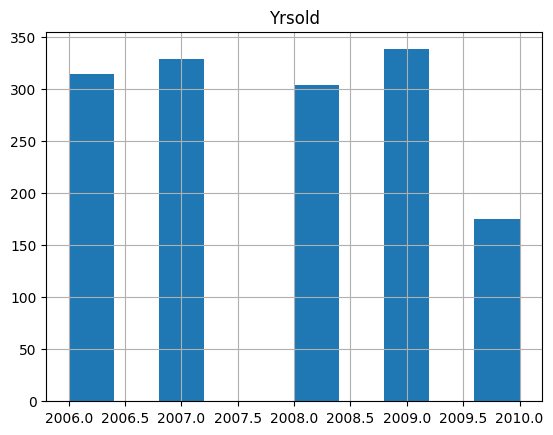

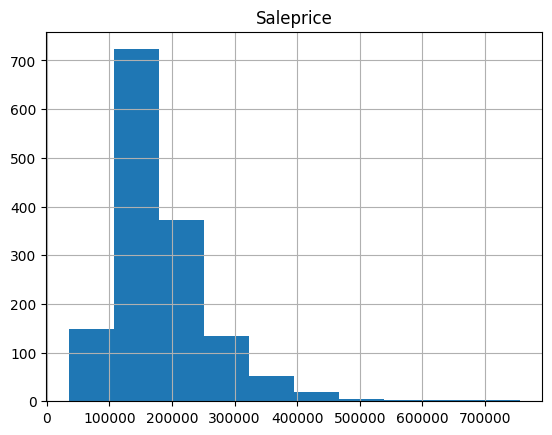

In [12]:
for col in df.select_dtypes('number'):
    df[col].hist()
    plt.title(col.capitalize())

    plt.show()

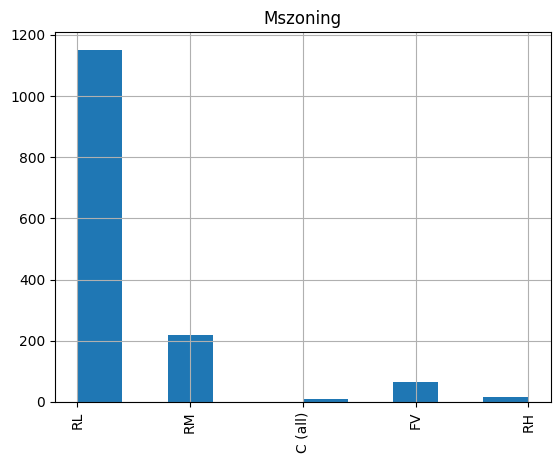

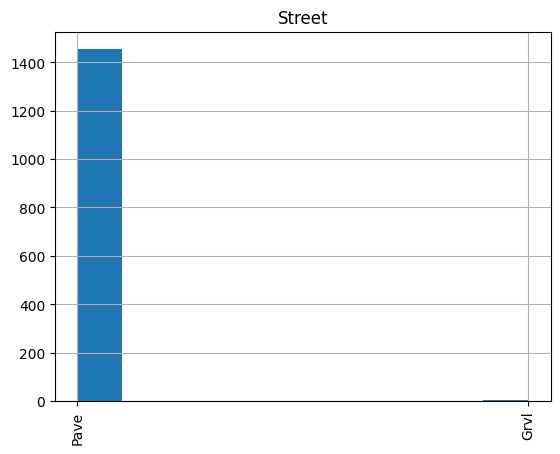

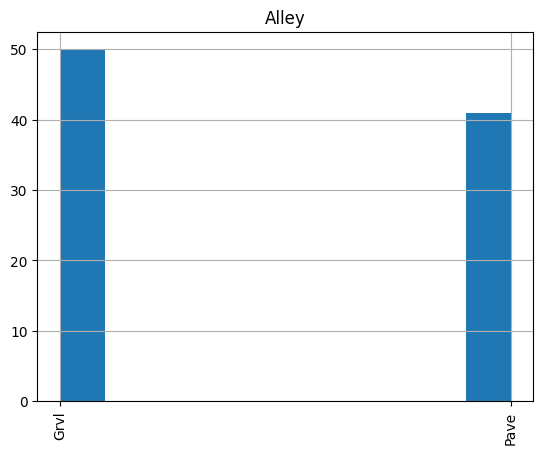

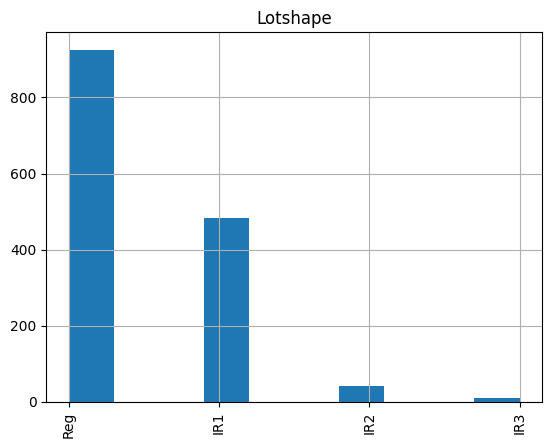

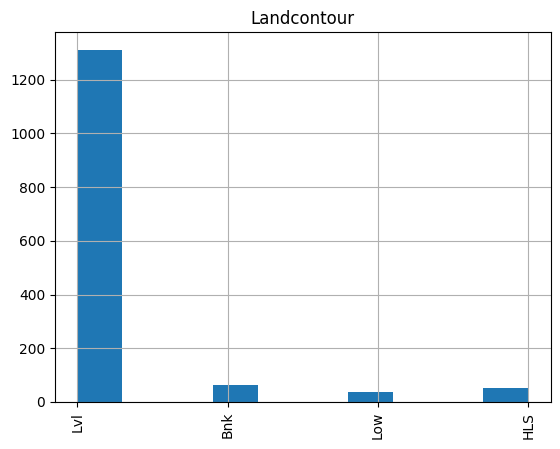

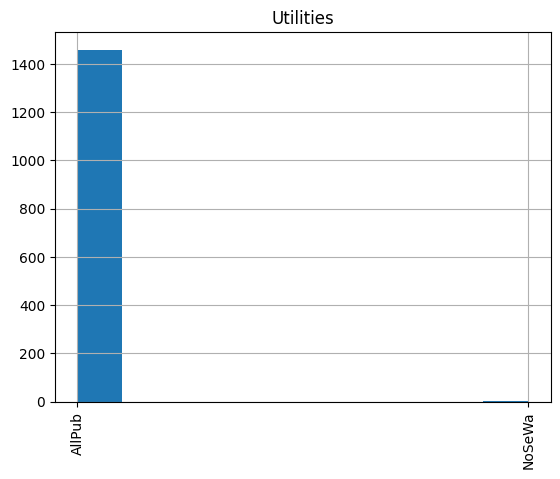

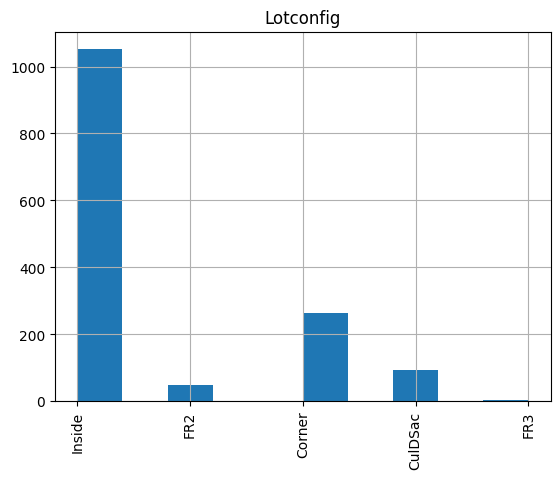

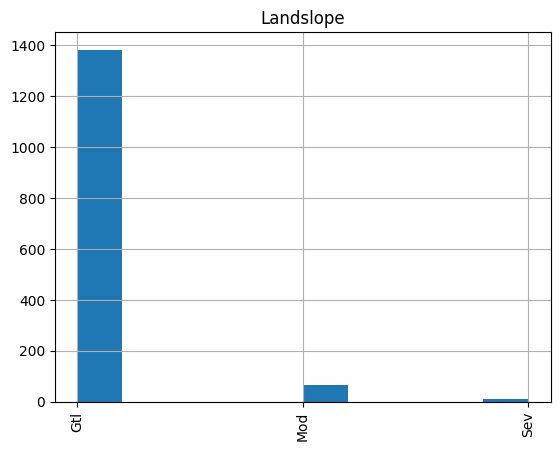

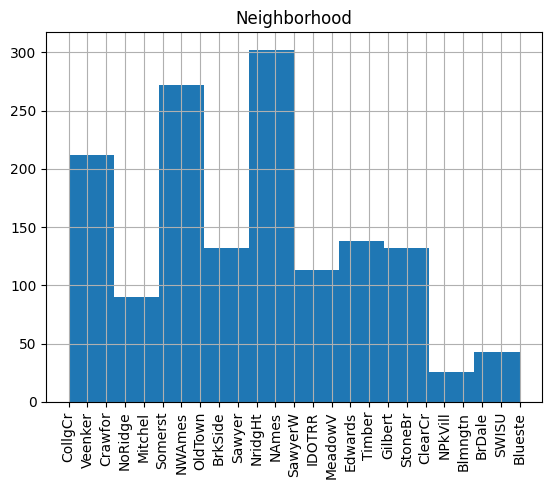

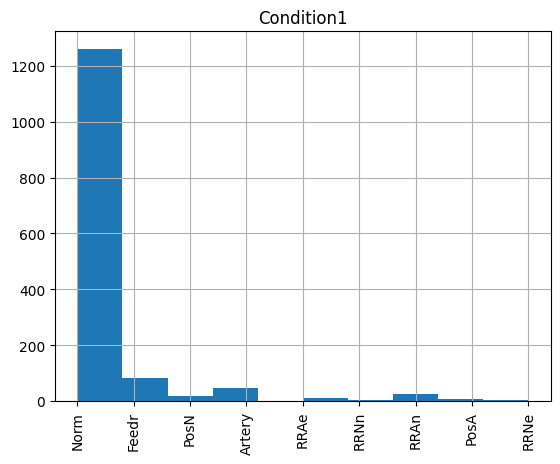

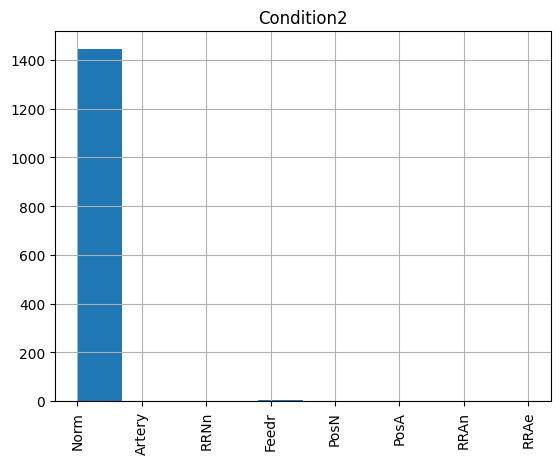

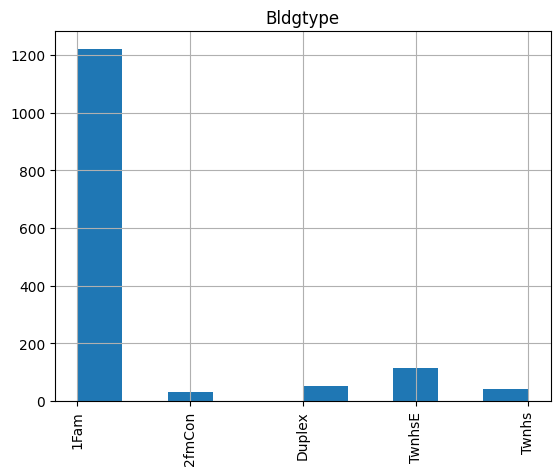

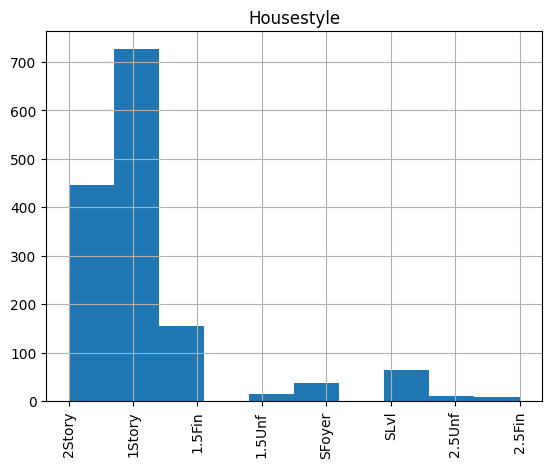

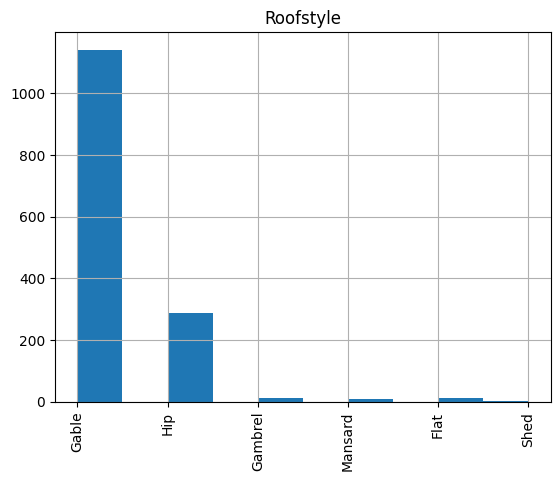

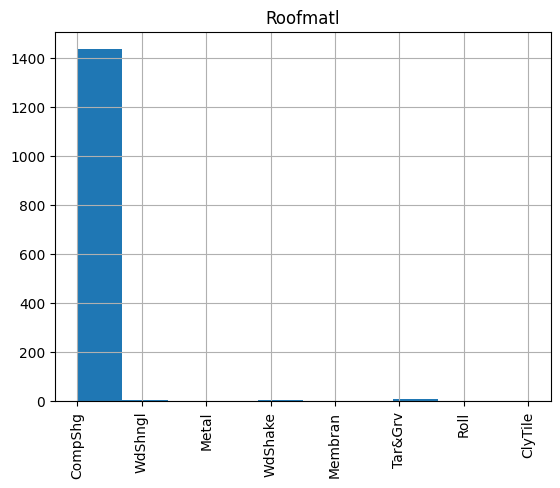

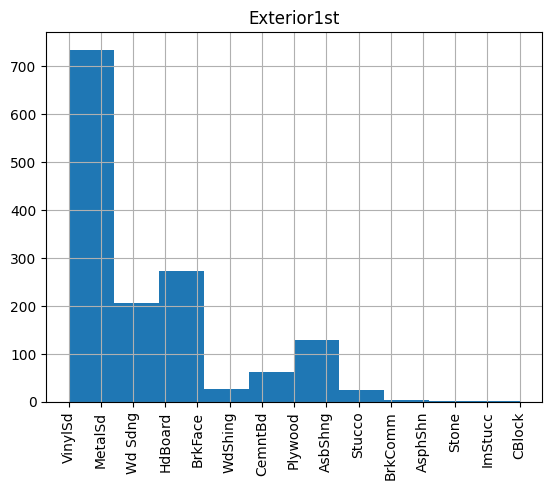

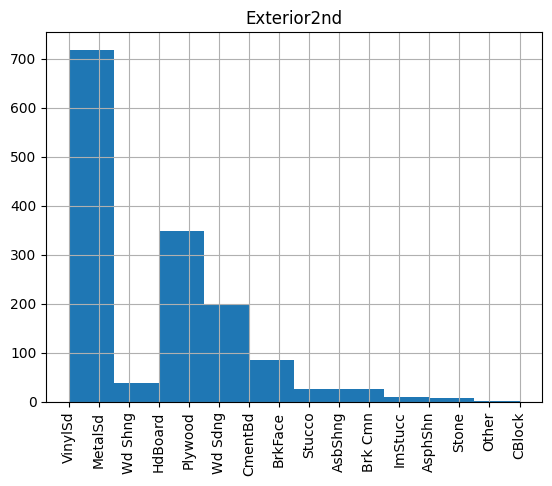

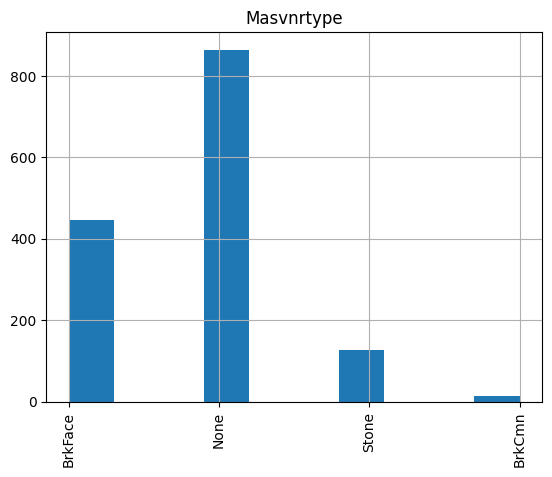

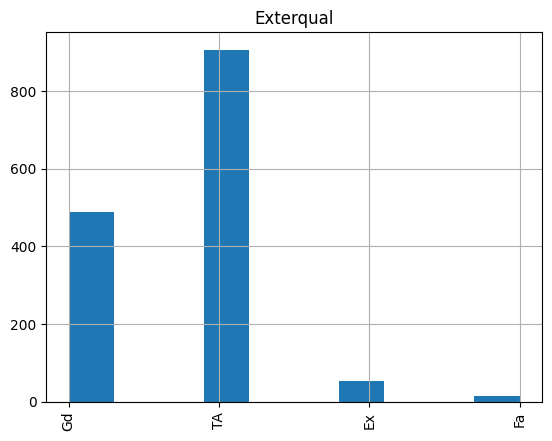

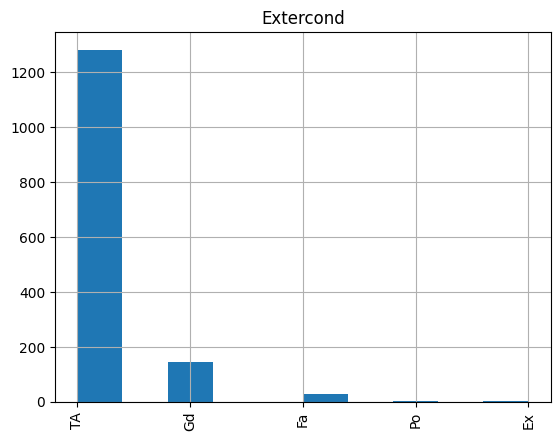

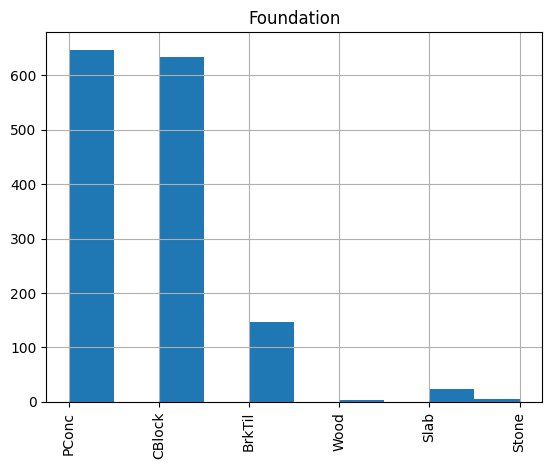

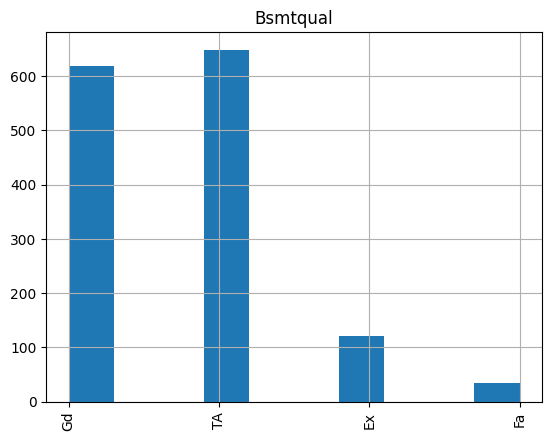

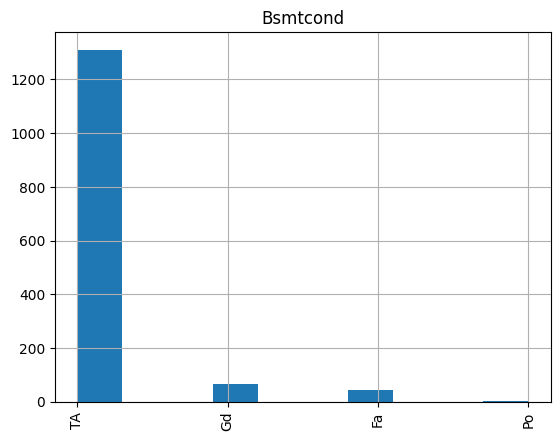

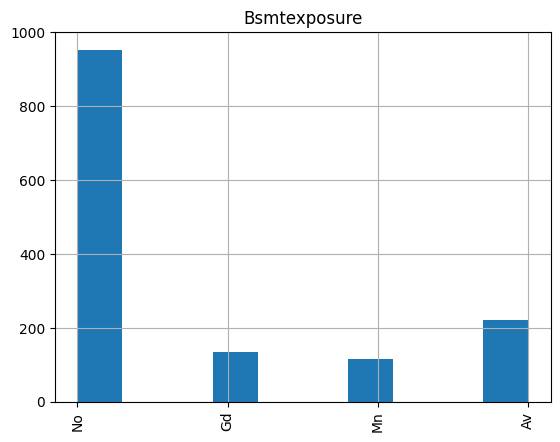

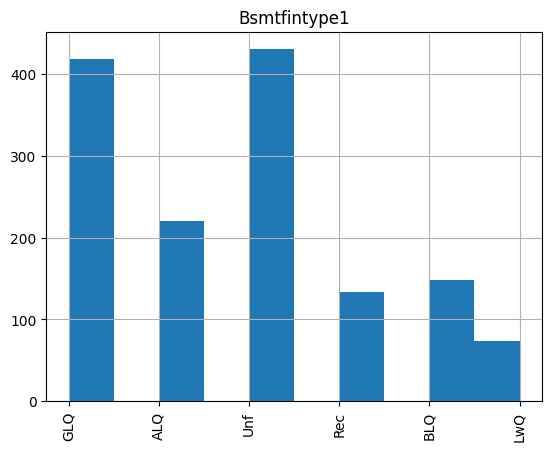

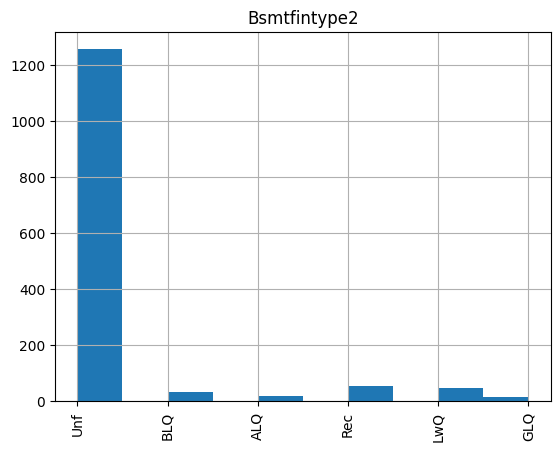

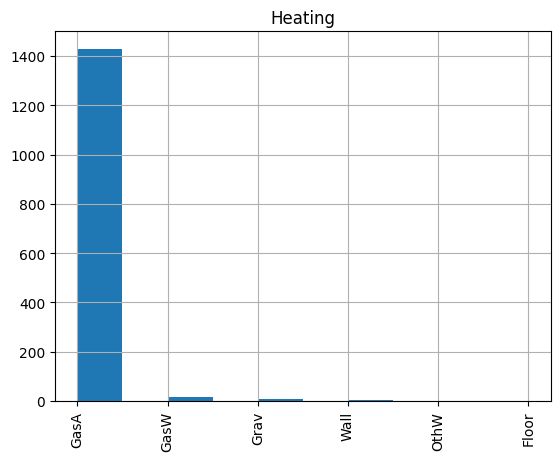

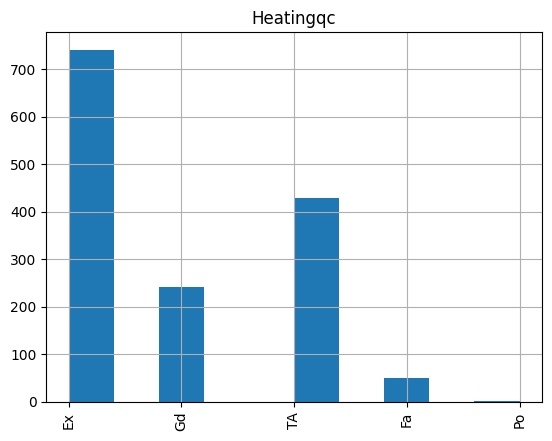

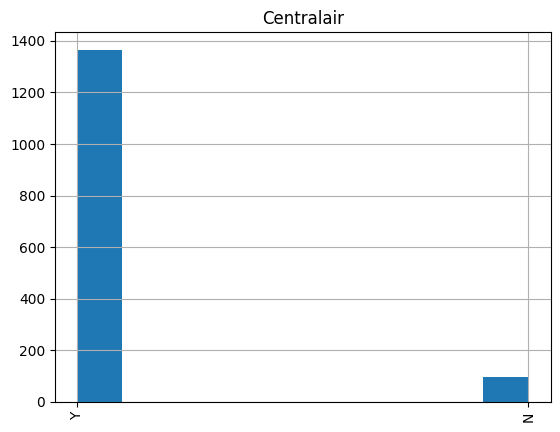

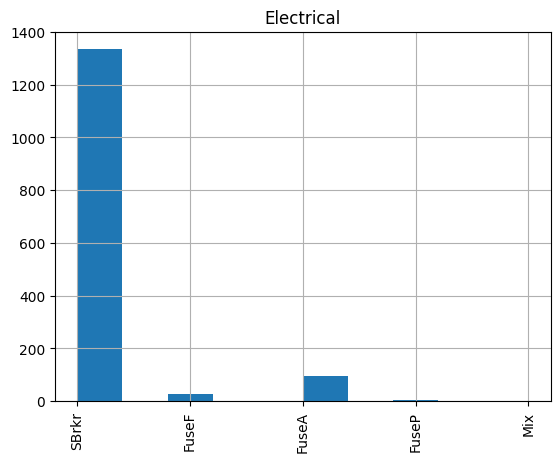

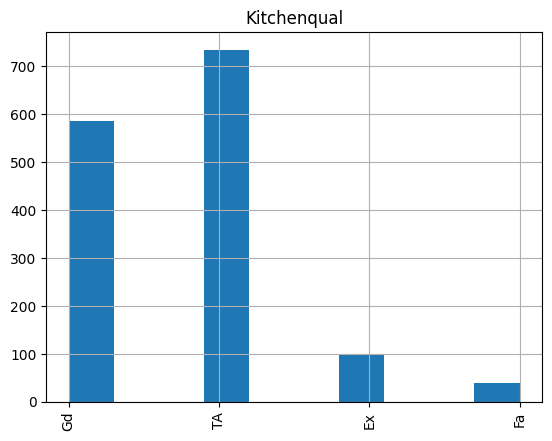

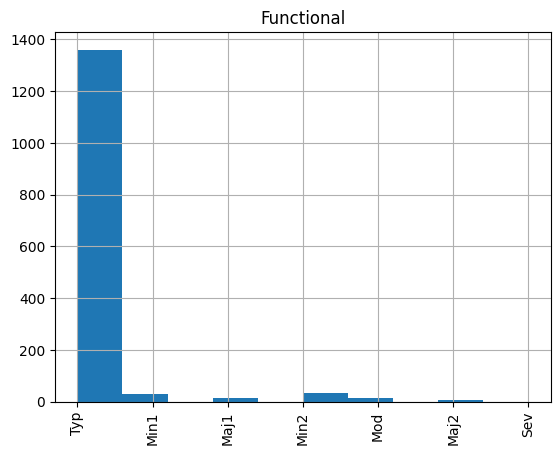

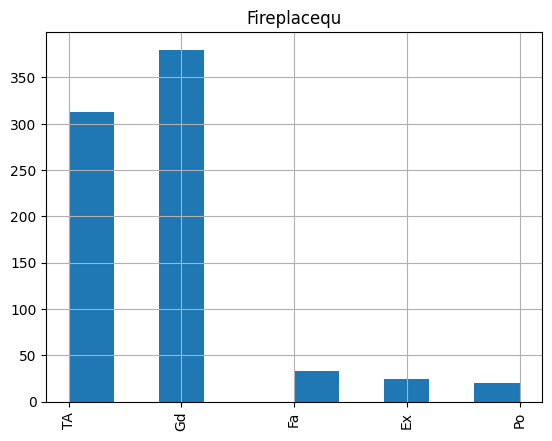

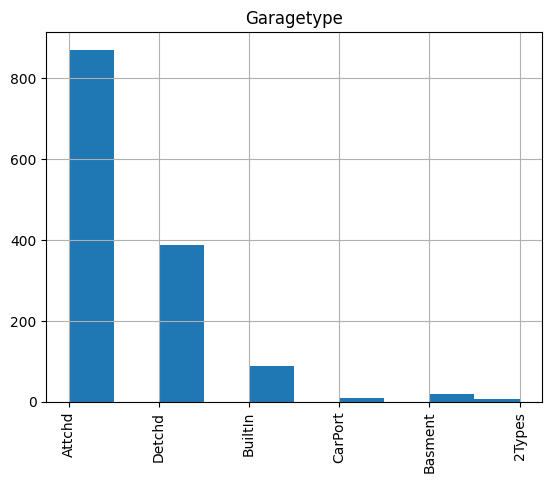

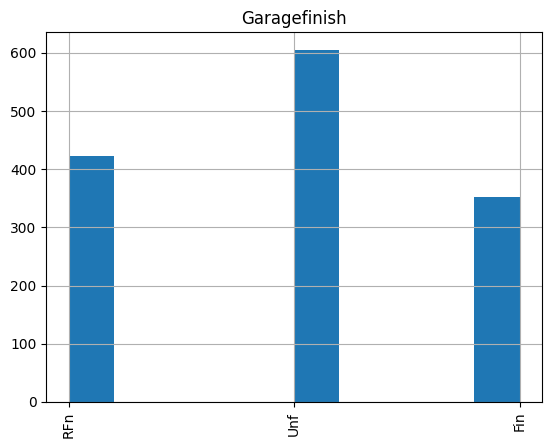

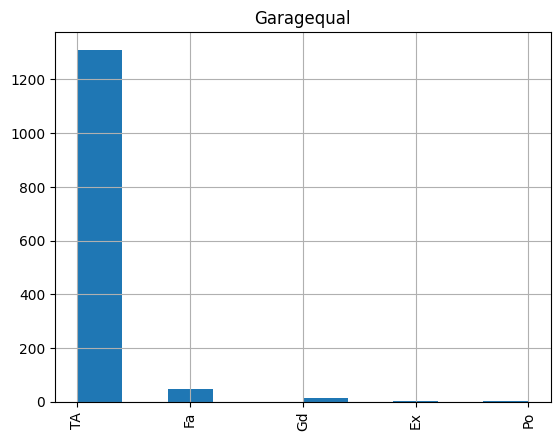

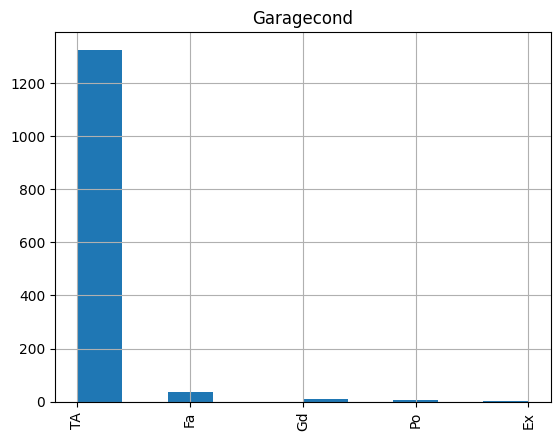

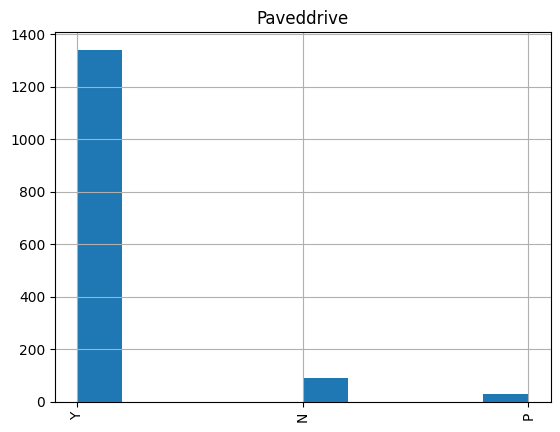

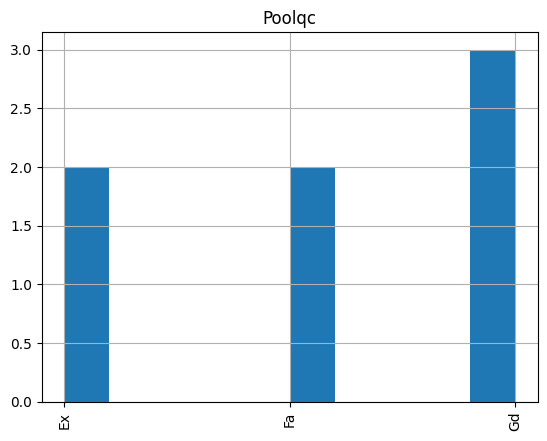

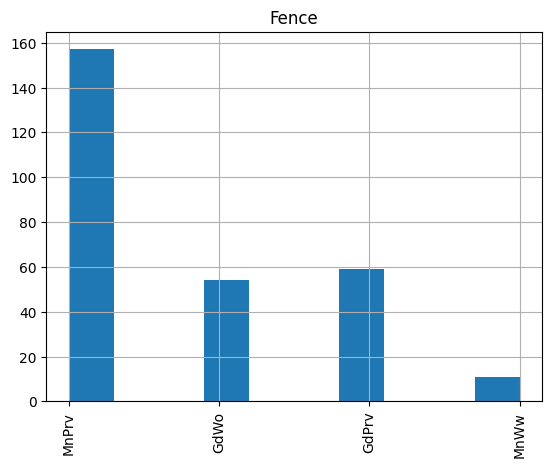

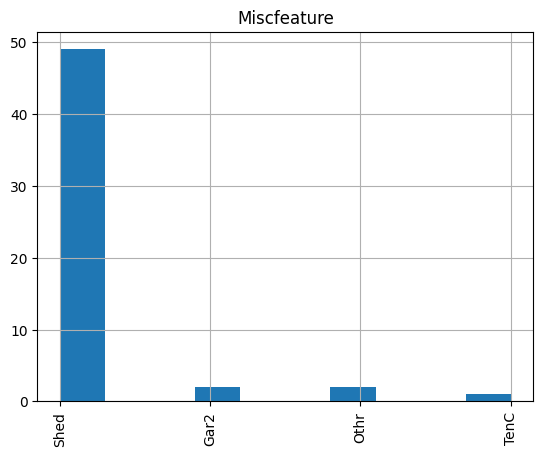

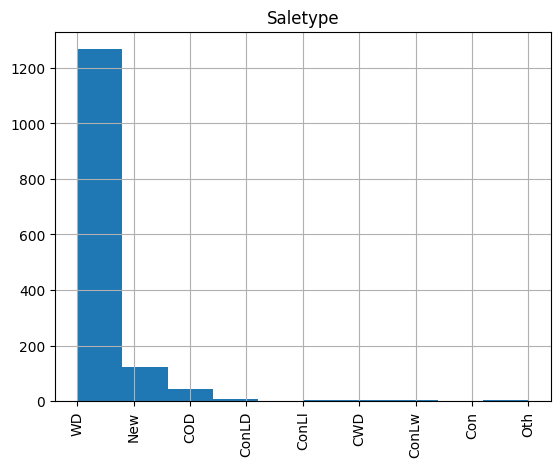

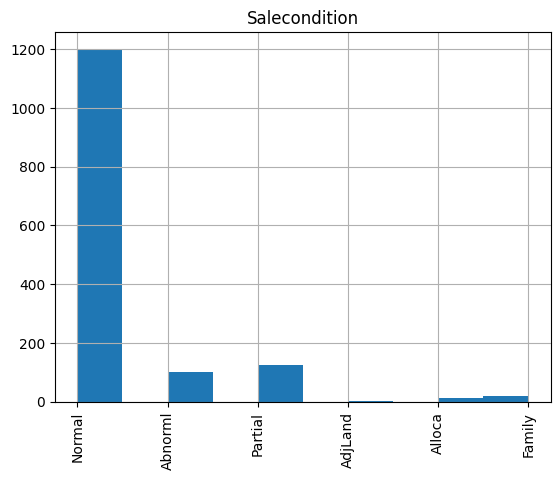

In [13]:
for col in df.select_dtypes('object'):
    df[col].hist()
    plt.title(col.capitalize())
    plt.xticks(rotation=90)
    plt.show()

Based on the EDA of all features above, decided to manually drop some columns before building neural network. Typically, if over 50% missing values per row, the values are the same or similar in a column it's enough to justify this option.

In [14]:
# Drop irrelevant, redundant and low variance object features
df = df.drop(["Street", "MiscFeature", 'Alley', 'LandContour', 'Utilities',
              'LandSlope', 'Condition2', 'RoofMatl', 'BsmtCond', 'Heating',
              'CentralAir', 'Functional', 'PavedDrive', 'PoolQC' , 'MiscFeature'
              ], axis=1)
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,Condition1,BldgType,...,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Reg,Inside,CollgCr,Norm,1Fam,...,0,0,0,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Reg,FR2,Veenker,Feedr,1Fam,...,0,0,0,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,IR1,Inside,CollgCr,Norm,1Fam,...,0,0,0,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,IR1,Corner,Crawfor,Norm,1Fam,...,0,0,0,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,IR1,FR2,NoRidge,Norm,1Fam,...,0,0,0,NaN,0,12,2008,WD,Normal,250000


In [15]:
print(df.info())
print('\n')
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 67 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   LotShape       1460 non-null   object 
 6   LotConfig      1460 non-null   object 
 7   Neighborhood   1460 non-null   object 
 8   Condition1     1460 non-null   object 
 9   BldgType       1460 non-null   object 
 10  HouseStyle     1460 non-null   object 
 11  OverallQual    1460 non-null   int64  
 12  OverallCond    1460 non-null   int64  
 13  YearBuilt      1460 non-null   int64  
 14  YearRemodAdd   1460 non-null   int64  
 15  RoofStyle      1460 non-null   object 
 16  Exterior1st    1460 non-null   object 
 17  Exterior2nd    1460 non-null   object 
 18  MasVnrTy

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,Condition1,BldgType,...,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Reg,Inside,CollgCr,Norm,1Fam,...,0,0,0,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Reg,FR2,Veenker,Feedr,1Fam,...,0,0,0,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,IR1,Inside,CollgCr,Norm,1Fam,...,0,0,0,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,IR1,Corner,Crawfor,Norm,1Fam,...,0,0,0,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,IR1,FR2,NoRidge,Norm,1Fam,...,0,0,0,NaN,0,12,2008,WD,Normal,250000


# **Cap Outliers for Target**

In [16]:
def find_outliers_IQR(df):

   q1 = df.quantile(0.25)

   q3 = df.quantile(0.75)

   IQR = q3-q1

   outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]

   return outliers

In [17]:
outliers = find_outliers_IQR(df['SalePrice'])

print("number of outliers: "+ str(len(outliers)))

print("max outlier value: "+ str(outliers.max()))

print("min outlier value: "+ str(outliers.min()))

outliers

number of outliers: 61
max outlier value: 755000
min outlier value: 341000


11      345000
53      385000
58      438780
112     383970
151     372402
         ...  
1268    381000
1353    410000
1373    466500
1388    377500
1437    394617
Name: SalePrice, Length: 61, dtype: int64

In [18]:
upper_limit = df['SalePrice'].mean() + 3*df['SalePrice'].std()

print(upper_limit)

lower_limit = df['SalePrice'].mean() - 3*df['SalePrice'].std()

print(lower_limit)

419248.70453907084
-57406.31275824891


In [19]:
df['SalePrice'] = np.where(df['SalePrice'] > upper_limit,
                    upper_limit, np.where(df['SalePrice'] < lower_limit,
                    lower_limit, df['SalePrice']))

In [20]:
df.describe()[['SalePrice']]

,SalePrice
count,1460.000000
mean,179512.256507
std,73240.906241
min,34900.000000
25%,129975.000000
50%,163000.000000
75%,214000.000000
max,419248.704539


# **Train Test Split**

In [21]:
# Define X and Y and complete the train test split
X = df.drop(columns = ['SalePrice'])
y = df['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

# **Scaling the Data**

In [22]:
# Transformers
mean_imputer = SimpleImputer(strategy='mean', fill_value='missing')
scaler = StandardScaler()

#Pipeline
num_pipe = make_pipeline(mean_imputer, scaler)

#Selector
num_selector = make_column_selector(dtype_include='number')

#Tuple
num_tuple = (num_pipe, num_selector)

In [23]:
# Transformers
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
freq_imputer = SimpleImputer(strategy='constant', fill_value='missing')

#Pipeline
cat_pipe = make_pipeline(freq_imputer, ohe)

#Selector
cat_selector = make_column_selector(dtype_include='object')

#Tuple
cat_tuple = (cat_pipe, cat_selector)

In [24]:
# Instantiate the make column transformer
preprocessor = make_column_transformer(num_tuple, cat_tuple, remainder='drop', verbose_feature_names_out=False)

In [25]:
# Scale the data
preprocessor.fit(X_train)
X_train_proc = preprocessor.transform(X_train)
X_test_proc = preprocessor.transform(X_test)

In [26]:
print(np.isnan(X_train_proc).sum().sum(), 'missing values \n')
X_train_proc

0 missing values 



array([[ 0.69831455,  1.47591094, -1.20217378, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.19637178, -0.87122795,  0.33376282, ...,  0.        ,
         1.        ,  0.        ],
       [ 1.54902506, -0.16708628, -0.45614743, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 1.33693656, -0.87122795, -0.45614743, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.31419872, -0.16708628, -0.67556694, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.94103804,  1.47591094, -0.76333475, ...,  0.        ,
         1.        ,  0.        ]])

# **Deep Learning Models**

## **Model 1**

In [27]:
# Set Random Seeds
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

input_shape = X_train_proc.shape[1]

# Instantiate the sequential model
model1 = Sequential()

# Hidden layers
model1.add(Dense(input_shape, input_dim=input_shape, activation='relu'))
model1.add(Dense(50, activation='relu'))
model1.add(Dense(30, activation='relu'))

# Output layer
model1.add(Dense(1, activation='linear'))

# Check summary of network
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 242)               58806     
                                                                 
 dense_1 (Dense)             (None, 50)                12150     
                                                                 
 dense_2 (Dense)             (None, 30)                1530      
                                                                 
 dense_3 (Dense)             (None, 1)                 31        
                                                                 
Total params: 72,517
Trainable params: 72,517
Non-trainable params: 0
_________________________________________________________________


### **Compiling the Data**

In [28]:
# Compile model with additional metrics

from keras.metrics import RootMeanSquaredError

tf.keras.optimizers.legacy.Adam()

rmse = RootMeanSquaredError()

model1.compile(loss='mse', optimizer='adam', metrics=['mae', rmse])

### **Fitting the Data**

In [29]:
# Fit the model

history1 = model1.fit(X_train_proc, y_train,
                        validation_data = (X_test_proc, y_test),
                        epochs = 200, verbose=0)

### **Plot the Data**

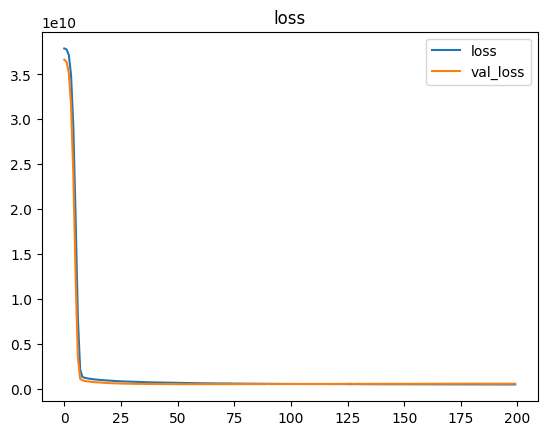

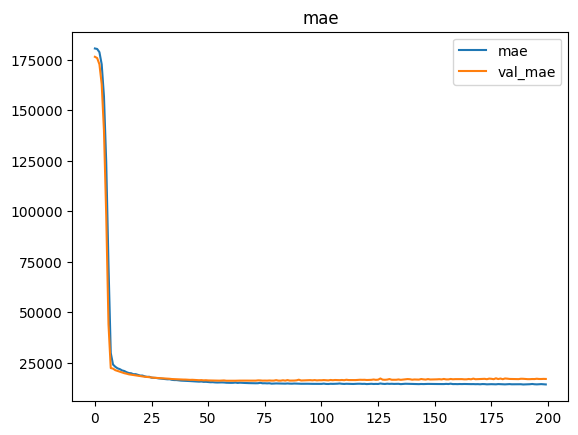

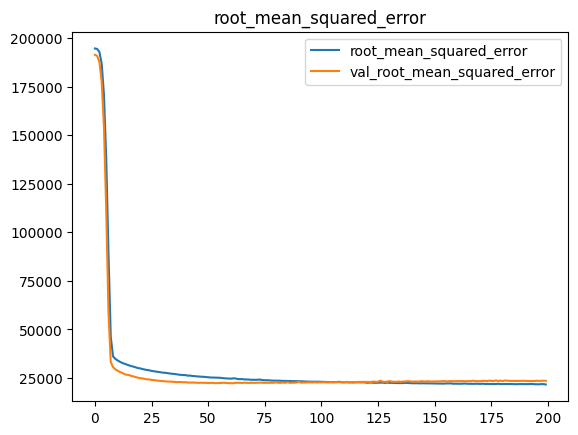

In [30]:
# Plot Learning
plot_history(history1)

### **Evaluation**

In [31]:
# Make predictions and evaluate the model

train_1_preds = model1.predict(X_train_proc)
test_1_preds = model1.predict(X_test_proc)

train_1_scores = eval_regression(y_train, train_1_preds, name='reg_train_1')
test_1_scores = eval_regression(y_test, test_1_preds, name='reg_test_1')

reg_scores = pd.concat([train_1_scores, test_1_scores])
reg_scores

12/12 [==============================] - 0s 3ms/step


,RMSE,MAE,R2
Model Name,,,
reg_train_1,21505.949708,14158.762116,0.912776
reg_test_1,23497.735490,16964.894611,0.900016


## **Model 2**

In [32]:
# Set Random Seeds
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

input_shape = X_train_proc.shape[1]

# Instantiate the sequential model
model2 = Sequential()

# Hidden layers
model2.add(Dense(input_shape, input_dim=input_shape, activation='relu',
                 kernel_regularizer=regularizers.l1_l2(l1=.01, l2=.01)))
model2.add(Dense(50, activation='relu',
                 kernel_regularizer=regularizers.l1_l2(l1=.01, l2=.01)))
model2.add(Dense(30, activation='relu',
                 kernel_regularizer=regularizers.l1_l2(l1=.01, l2=.01)))

# Output layer
model2.add(Dense(1, activation='linear'))

# Check summary of network
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 242)               58806     
                                                                 
 dense_1 (Dense)             (None, 50)                12150     
                                                                 
 dense_2 (Dense)             (None, 30)                1530      
                                                                 
 dense_3 (Dense)             (None, 1)                 31        
                                                                 
Total params: 72,517
Trainable params: 72,517
Non-trainable params: 0
_________________________________________________________________


### **Compiling the Data**

In [33]:
# Compile model with additional metrics

from keras.metrics import RootMeanSquaredError

tf.keras.optimizers.legacy.Adam()

rmse = RootMeanSquaredError()

model2.compile(loss='mse', optimizer='adam', metrics=['mae', rmse])

### **Fitting the Data**

In [34]:
# Fit the model

history2 = model2.fit(X_train_proc, y_train,
                        validation_data = (X_test_proc, y_test),
                        epochs = 200, verbose=0)

### **Plot the Data**

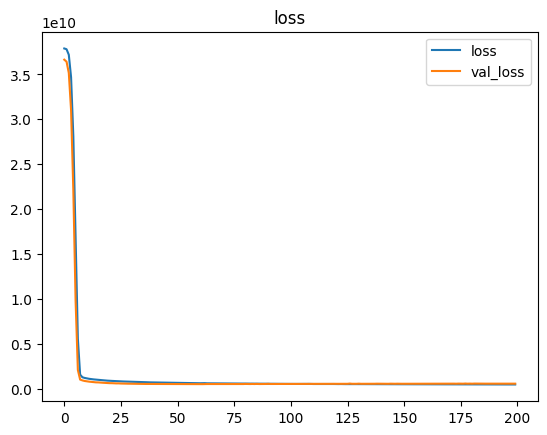

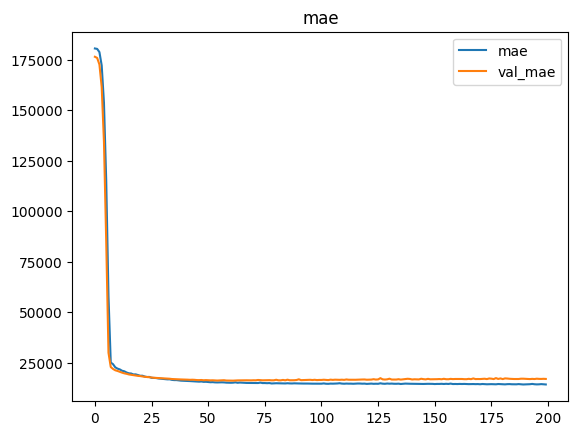

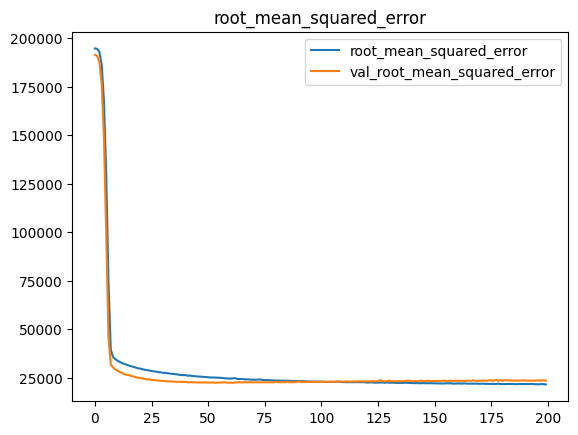

In [35]:
# Plot Learning
plot_history(history2)

### **Evaluation**

In [36]:
# Make predictions and evaluate the model

train_2_preds = model2.predict(X_train_proc)
test_2_preds = model2.predict(X_test_proc)

train_2_scores = eval_regression(y_train, train_2_preds, name='reg_train_2')
test_2_scores = eval_regression(y_test, test_2_preds, name='reg_test_2')

reg_scores2 = pd.concat([train_2_scores, test_2_scores])
reg_scores2

12/12 [==============================] - 0s 3ms/step


,RMSE,MAE,R2
Model Name,,,
reg_train_2,21296.939236,14029.461103,0.914463
reg_test_2,23426.315761,16868.511563,0.900623


## **Model 3**

In [37]:
# Set Random Seeds
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

input_shape = X_train_proc.shape[1]

# Instantiate the sequential model
model3 = Sequential()

# Hidden layers
model3.add(Dense(input_shape, input_dim=input_shape, activation='relu'))
model3.add(Dense(50, activation='relu'))
model3.add(Dense(30, activation='relu'))

# Output layer
model3.add(Dense(1, activation='linear'))

# Check summary of network
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 242)               58806     
                                                                 
 dense_1 (Dense)             (None, 50)                12150     
                                                                 
 dense_2 (Dense)             (None, 30)                1530      
                                                                 
 dense_3 (Dense)             (None, 1)                 31        
                                                                 
Total params: 72,517
Trainable params: 72,517
Non-trainable params: 0
_________________________________________________________________


### **Compiling the Data**

In [38]:
# Compile model with additional metrics

from keras.metrics import RootMeanSquaredError

tf.keras.optimizers.legacy.Adam()

rmse = RootMeanSquaredError()

model3.compile(loss='mse', optimizer='adam', metrics=['mae', rmse])

### **Fitting the Data**

In [39]:
# Fit the model
early_stopping = EarlyStopping(patience = 5)

history3 = model3.fit(X_train_proc, y_train,
                        validation_data = (X_test_proc, y_test),
                        epochs = 200, callbacks=[early_stopping], verbose=0)

### **Plot the Data**

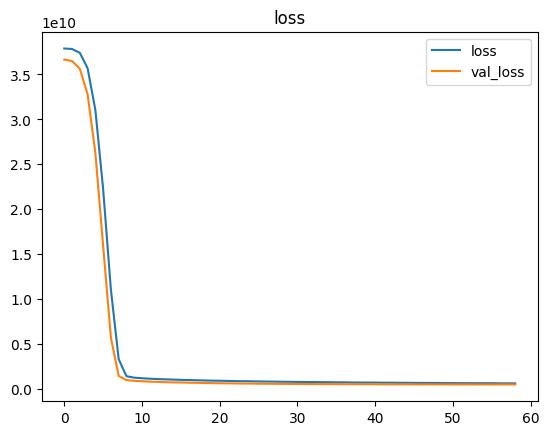

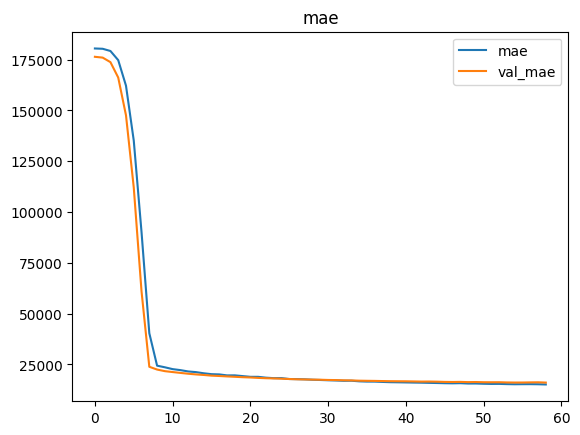

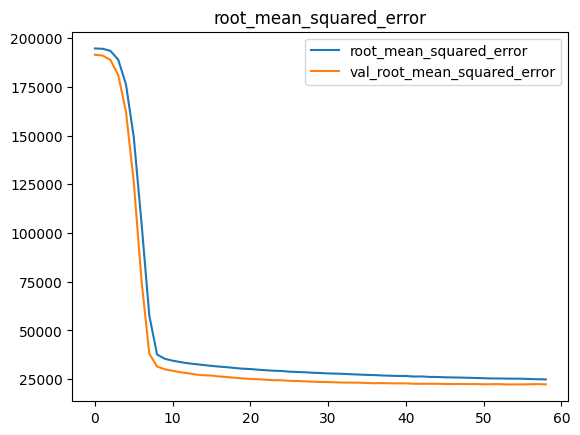

In [40]:
# Plot Learning
plot_history(history3)

### **Evaluation**

In [47]:
# Make predictions and evaluate the model

train_3_preds = model3.predict(X_train_proc)
test_3_preds = model3.predict(X_test_proc)

train_3_scores = eval_regression(y_train, train_3_preds, name='reg_train_3')
test_3_scores = eval_regression(y_test, test_3_preds, name='reg_test_3')

reg_scores3 = pd.concat([train_3_scores, test_3_scores])
reg_scores3

12/12 [==============================] - 0s 8ms/step


,RMSE,MAE,R2
Model Name,,,
reg_train_3,24679.445271,15037.549346,0.885134
reg_test_3,22310.702219,16053.719761,0.909863


# **Conclusion**

Based on the above models, the best model suggested for predicting housing prices is model 3. Between the metrics and plots displaying the least amount of errors and the highest variance in the target at 91%; it's then considered the best performing model.